# 프로젝트 : CAM & Grad-CAM 시각화
2024-07-05
### 데이터 : stanford_dogs
### 모델 : ResNet50

### 1. CAM
### 2. Grad-CAM
### 3. Bounding Box
- Grad-CAM
- IOU

## 0. 라이브러리

In [5]:
import tensorflow as tf
import numpy as np
import cv2
import PIL
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# model,history save,load
import pickle
print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

tf.config.list_physical_devices('GPU')

2.6.0
1.21.4
4.5.3
8.3.2


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터

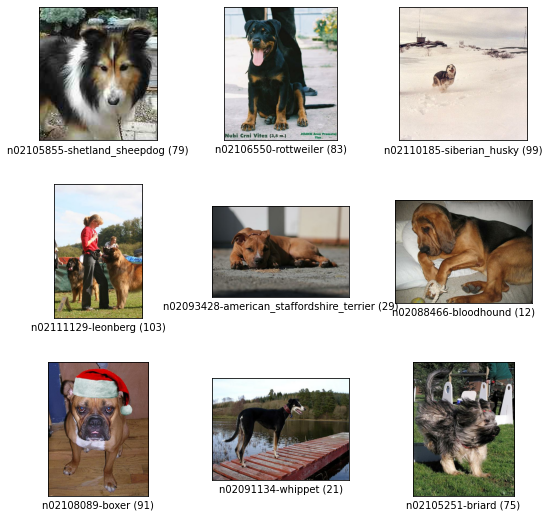

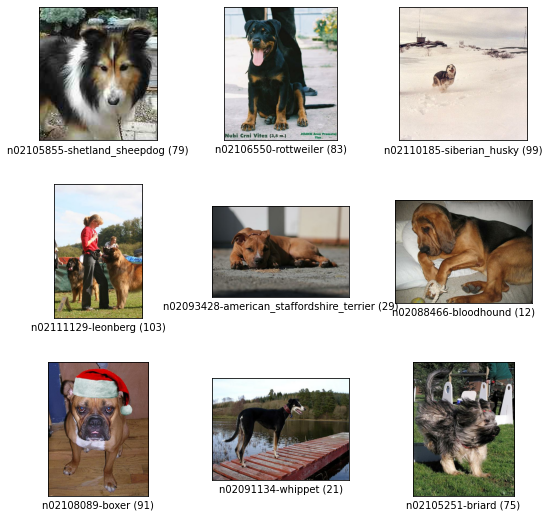

In [6]:
data_dir = '/aiffel/aiffel/aiffel_quest'

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir=data_dir
)
num_classes = ds_info.features['label'].num_classes
tfds.show_examples(ds_train, ds_info)

## 2. 전처리

In [7]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


## 3. ResNet50 모델
### 3.1 모델 정의

In [9]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output

# 분류 층 추가
preds = keras.layers.Dense(num_classes, activation='softmax')(x)

# 새로운 모델 정의
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


### 3.2 모델 학습

In [13]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 167s 208ms/step - loss: 2.2183 - accuracy: 0.4405 - val_loss: 3.6840 - val_accuracy: 0.1691
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 0.7301 - accuracy: 0.7972 - val_loss: 1.2672 - val_accuracy: 0.6391
Epoch 3/20
750/750 [==============================] - 154s 206ms/step - loss: 0.2399 - accuracy: 0.9486 - val_loss: 0.9308 - val_accuracy: 0.7265
Epoch 4/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0676 - accuracy: 0.9938 - val_loss: 0.9280 - val_accuracy: 0.7366
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0277 - accuracy: 0.9990 - val_loss: 0.9136 - val_accuracy: 0.7425
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0167 - accuracy: 0.9996 - val_loss: 0.9251 - val_accuracy: 0.7415
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0137 - accuracy: 0.9993 - val_loss: 0.9520 -

### 3.3 모델 저장

In [15]:
drive_path = '/aiffel/aiffel/aiffel_quest/GoingDeeper/Quest3/models/'

# no_aug_resnet50 모델 저장 (아무것도 적용하지 않은 데이터셋 사용)
cam_model.save(drive_path + 'cam_model1.h5')

with open(drive_path + 'history_cam_model.pkl', 'wb') as f:
    pickle.dump(history_cam_model.history, f)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
